##  Liar

In [91]:
import numpy as np
import pandas as pd
import os
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk import  pos_tag
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec


from textblob import TextBlob

import matplotlib.pyplot as plt 
from matplotlib import rcParams

import seaborn as sns

from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import StandardScaler


from sklearn.linear_model import LogisticRegression

from collections import Counter

import scipy.sparse  
from scipy.sparse import hstack, csr_matrix


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error



In [2]:
#nltk.download('averaged_perceptron_tagger')
#nltk.download('punkt')


In [3]:
base_dir= '.' 
dataset= 'liar_dataset'
data_dir= os.path.join(base_dir, dataset)

In [4]:
file= 'politifact_factcheck_data.json'
adrs= os.path.join(data_dir, file)

In [5]:
Liar_train= pd.read_csv(os.path.join(data_dir,'train.tsv'), sep='\t')
Liar_test= pd.read_csv(os.path.join(data_dir, 'test.tsv'), sep='\t')


## Cleanning Liar

In [6]:
Liar_train.columns= ['[ID].json','label','statement','subject','speaker',"speaker's job title",'state info','party affiliation','barely true counts',
'false counts','half true counts','mostly true counts','pants on fire counts','the context']
Liar_test.columns= ['[ID].json','label','statement','subject','speaker',"speaker's job title",'state info','party affiliation','barely true counts',
'false counts','half true counts','mostly true counts','pants on fire counts','the context']

In [7]:
Liar= pd.concat([Liar_train, Liar_test], axis= 0)


In [8]:
Liar.head(3)

,[ID].json,label,statement,subject,speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,the context
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release


In [9]:
Liar['subject']= Liar['subject'].apply(lambda x: str(x).replace(',', ' '))

In [10]:
Liar.head(3)

,[ID].json,label,statement,subject,speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants on fire counts,the context
0,10540.json,half-true,When did the decline of coal start? It started...,energy history job-accomplishments,scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release


In [11]:
count_of_source =Liar['state info'].value_counts()
count_of_source

Texas             1131
Florida           1114
Wisconsin          814
New York           742
Illinois           624
                  ... 
United Kingdom       1
China                1
Rhode island         1
New Hampshire        1
Rhode Island         1
Name: state info, Length: 84, dtype: int64

In [12]:
count_of_source =Liar['state info'].value_counts()
count_of_source

Texas             1131
Florida           1114
Wisconsin          814
New York           742
Illinois           624
                  ... 
United Kingdom       1
China                1
Rhode island         1
New Hampshire        1
Rhode Island         1
Name: state info, Length: 84, dtype: int64

In [13]:
count_of_source =Liar['party affiliation'].value_counts()
count_of_source

republican                      5066
democrat                        3742
none                            1958
organization                     246
independent                      161
newsmaker                         57
journalist                        47
libertarian                       45
columnist                         42
activist                          41
talk-show-host                    29
state-official                    24
labor-leader                      11
business-leader                   10
tea-party-member                  10
green                              3
education-official                 2
government-body                    2
constitution-party                 2
liberal-party-canada               1
Moderate                           1
democratic-farmer-labor            1
ocean-state-tea-party-action       1
county-commissioner                1
Name: party affiliation, dtype: int64

In [14]:
# merging two columns 
Liar['news']= Liar['subject']+ Liar['statement']

In [15]:
# factorizing, converting some columns text to code 
Liar["speaker"] = pd.factorize(Liar["speaker"])[0]
Liar["speaker's job title"] = pd.factorize(Liar["speaker's job title"])[0]
Liar["state info"]= pd.factorize(Liar['state info'])[0]
Liar["party affiliation"]= pd.factorize(Liar['party affiliation'])[0]
Liar["the context"]= pd.factorize(Liar['the context'])[0]


In [16]:
Liar.drop(['[ID].json', 'subject','statement', 'barely true counts', 
           'false counts','half true counts', 'mostly true counts',
          'pants on fire counts'], inplace= True ,   axis= 1)

In [17]:
Liar.head(2)

,label,speaker,speaker's job title,state info,party affiliation,the context,news
0,half-true,0,0,0,0,0,energy history job-accomplishmentsWhen did the...
1,mostly-true,1,1,1,0,1,foreign-policyHillary Clinton agrees with John...


In [18]:
Liar['label'].value_counts()

half-true      2379
false          2243
mostly-true    2203
true           1883
barely-true    1866
pants-fire      931
Name: label, dtype: int64

In [19]:
# Labeling 
mask= Liar['label'].str.contains('barely-true', case= False)
Liar.loc[mask, 'label'] = 'false' # change barely-true lable to False 

mask= Liar['label'].str.contains('true', case= False)
Liar.loc[mask, 'label'] = 1  # Real

mask= Liar['label']!= 1
Liar.loc[mask, 'label'] = 0 # Fake

In [20]:
Liar.head(2)

,label,speaker,speaker's job title,state info,party affiliation,the context,news
0,1,0,0,0,0,0,energy history job-accomplishmentsWhen did the...
1,1,1,1,1,0,1,foreign-policyHillary Clinton agrees with John...


In [21]:
#save point one
Liar.to_csv(os.path.join(data_dir, 'Liar.csv'), index=False)

# Stopwords

In [22]:
#task2 : remove marks and stopwords
# defining a funtion to make the lowercase and remove links, square brackets, punctuation and words contianing numbers 
def review_cleaning(text):
    '''
    make the lowercase and remove links, square brackets, punctuation and words contianing numbers.  
    '''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(',()''', '', text)
    return text

In [23]:
# Tokenization and stopword
stop = stopwords.words('english')

Liar['news'] = Liar['news'].apply(lambda text: review_cleaning(text))

Liar['news']= Liar['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [24]:
# Applying Part of Speech
Liar['news']= pos_tag(Liar['news'])

In [25]:
# Save point 2 
Liar.to_csv(os.path.join(data_dir,'Liar_Stpwrd.csv'), index=False)

In [26]:
## EDA 

In [27]:
# Liar_Stpwrd after stopword and tokenization
Liar= pd.read_csv(os.path.join(data_dir,'Liar_Stpwrd.csv'))


In [28]:
Liar.head()

,label,speaker,speaker's job title,state info,party affiliation,the context,news
0,1,0,0,0,0,0,('energy history jobaccomplishmentswhen declin...
1,1,1,1,1,0,1,('foreignpolicyhillary clinton agrees john mcc...
2,0,2,-1,-1,1,2,('healthcarehealth care reform legislation lik...
3,1,3,-1,2,0,3,('economy jobsthe economic turnaround started ...
4,1,4,2,3,2,4,('educationthe chicago bears starting quarterb...


In [29]:
# finding columns which has NaN
columns_with_nan = Liar.columns[Liar.isnull().any()].tolist()
columns_with_nan

[]

In [30]:
# fill NaNs with zeros
Liar = Liar.fillna(Liar.mean(numeric_only=True))


In [31]:
non_numeric_columns = Liar.select_dtypes(exclude=['number']).columns
non_numeric_columns

Index(['news'], dtype='object')

## Feature Extraction

In [32]:
def feature_extraction(News, column):
    #Extracting the features from the news
    News['polarity'] = News[column].map(lambda text: TextBlob(str(text)).sentiment.polarity)
    News['review_len'] = News[column].astype(str).apply(len)
    News['word_count'] = News[column].apply(lambda x: len(str(x).split()))

    #Plotting the distribution of the extracted feature
    plt.figure(figsize = (20, 5))
    plt.style.use('seaborn-white')
    plt.subplot(131)
    sns.distplot(News['polarity'])
    fig = plt.gcf()
    plt.subplot(132)
    sns.distplot(News['review_len'])
    fig = plt.gcf()
    plt.subplot(133)
    sns.distplot(News['word_count'])
    fig = plt.gcf();

C:\Users\mahmoud\AppData\Local\Temp\ipykernel_6976\1703162373.py:9: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')
C:\Users\mahmoud\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\mahmoud\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) 

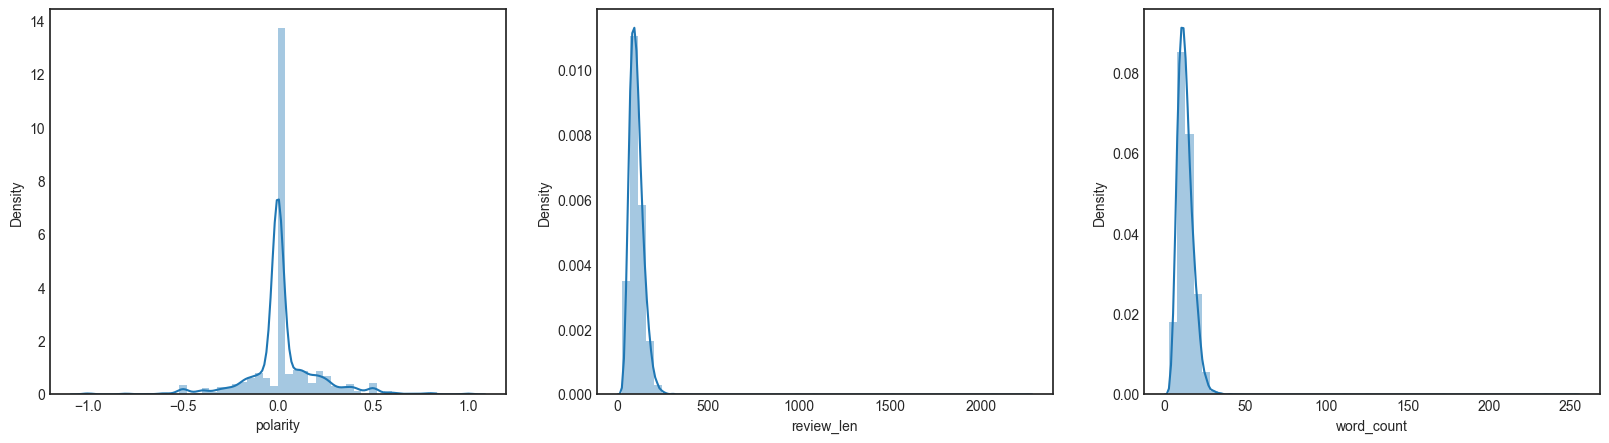

In [33]:
feature_extraction(Liar, 'news')

In [34]:
Liar.head(3)

,label,speaker,speaker's job title,state info,party affiliation,the context,news,polarity,review_len,word_count
0,1,0,0,0,0,0,('energy history jobaccomplishmentswhen declin...,0.1,145,18
1,1,1,1,1,0,1,('foreignpolicyhillary clinton agrees john mcc...,0.0,100,13
2,0,2,-1,-1,1,2,('healthcarehealth care reform legislation lik...,0.2,92,11


## Feature selection
#### Filter method

In [35]:
features= Liar.drop(['news', 'label'], axis= 1)
features.head(2)

,speaker,speaker's job title,state info,party affiliation,the context,polarity,review_len,word_count
0,0,0,0,0,0,0.1,145,18
1,1,1,1,0,1,0.0,100,13


In [36]:
# mutual_info_classif for feature selection
k_best_mi = SelectKBest(mutual_info_classif, k=6)  # Select top 6 features
features_selected_mi = k_best_mi.fit_transform(features, Liar['label'])
# features_selected_mi
selected_feature_indices = k_best_mi.get_support(indices=True)
selected_column_mi = set(features.columns[selected_feature_indices])
selected_column_mi

{'party affiliation',
 'polarity',
 'speaker',
 "speaker's job title",
 'state info',
 'the context'}

In [37]:
# f_classif for feature selection
k_best_f = SelectKBest(f_classif, k=6)  # Select top 6 features
X_selected_f = k_best_f.fit_transform(features, Liar['label'])
selected_feature_indices = k_best_mi.get_support(indices=True)
selected_column_f_class = set(features.columns[selected_feature_indices])
selected_column_f_class

{'party affiliation',
 'polarity',
 'speaker',
 "speaker's job title",
 'state info',
 'the context'}

In [38]:
# LASSO (L1 regularization) for feature selection
lasso_model = LogisticRegression(penalty='l1', solver='liblinear')
lasso_model.fit(features, Liar['label'])
# Get the absolute values of the coefficients
abs_coef = abs(lasso_model.coef_[0])

# Get the indices of the three largest coefficients (features with highest absolute coefficient values)
top_3_indices = abs_coef.argsort()[-6:][::-1]

# Get the names of the three best features
selected_features_lasso = features.columns[top_3_indices]

# Create the final feature matrix with the three selected features
features_selected_lasso = set(features[selected_features_lasso])

features_selected_lasso

{'party affiliation',
 'polarity',
 'review_len',
 "speaker's job title",
 'state info',
 'word_count'}

In [39]:
# 
# Calculate the correlation matrix
features= Liar.drop(['news'], axis= 1)
correlation_matrix = features.corr()

# Select features with high correlation to the target variable (absolute correlation values)
threshold = 0.015  
selected_features_corr = correlation_matrix[abs(correlation_matrix['label']) > threshold].index

# Create the final feature matrix
features_selected_corr = set(features[selected_features_corr])
features_selected_corr

{'label', 'party affiliation', 'state info', 'word_count'}

#### Wrapper methods
##### using lasso for all features including news column

In [40]:
# Creating bag of words
def bow(corpus):
    vectorizer = CountVectorizer()
    news_features = vectorizer.fit_transform(corpus).toarray()
    return news_features

In [41]:
news_bow= bow(Liar['news'])
print('Shape of bag of words on news: ', news_bow)
print('The number of new columns is added to dataset is: ', news_bow.shape[1])


Shape of bag of words on news:  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
The number of new columns is added to dataset is:  17578


In [42]:
type(news_bow)

numpy.ndarray

In [43]:
def cancat_two_part(dataset, vertorized_feature):
    # Step 1: Scale the numerical features using StandardScaler and convert to a sparse matrix
    other_features = dataset.drop(columns=['news', 'label'])
    scaler = StandardScaler()
    scaled_other_features = scaler.fit_transform(other_features)
    sparse_scaled_other_features = csr_matrix(scaled_other_features)

    # Step 2: Concatenate the sparse matrices for 'news' and numerical features
    all_features = hstack([vertorized_feature, sparse_scaled_other_features])

    return all_features

In [44]:
Liar_bow= cancat_two_part(Liar, news_bow)
Liar_bow

<11505x17586 sparse matrix of type '<class 'numpy.float64'>'
	with 236370 stored elements in COOrdinate format>

In [45]:
# Information Gain feature selection method

In [46]:
def informatio_gain(dataset, label):

    # Calculate Information Gain using mutual information
    information_gains_all = mutual_info_classif(dataset, label)  # Exclude non-numeric columns
    # Print Information Gains for each feature
    columns = [ 'speaker',"speaker's job title",'state info','party affiliation','the context','polarity','review_len', 'word_count'] 
    other_features= len(columns)
    selected_features= []
    information_gains= information_gains_all[-other_features:]
    for i, gain in enumerate(information_gains):
        print(f"Feature {columns[i]}: Information Gain = {gain:.6f}")
        selected_features.append(columns[i])
    return selected_features

In [47]:
selected_features_ig= informatio_gain(Liar_bow, Liar['label'])

Feature speaker: Information Gain = 0.226210
Feature speaker's job title: Information Gain = 0.097415
Feature state info: Information Gain = 0.014501
Feature party affiliation: Information Gain = 0.013820
Feature the context: Information Gain = 0.297633
Feature polarity: Information Gain = 0.044486
Feature review_len: Information Gain = 0.011056
Feature word_count: Information Gain = 0.002222


C:\Users\mahmoud\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\mahmoud\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\mahmoud\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\Users\mahmoud\anaconda3\lib\site-packages\sklearn\metrics\cluster\_supervised.py:65: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
C:\U

In [48]:
selected_features_ig

['speaker',
 "speaker's job title",
 'state info',
 'party affiliation',
 'the context',
 'polarity',
 'review_len',
 'word_count']

In [49]:
# Lasso feature selection method
def lasso_feature_selection(dataset, label):
    # getting features (X) and target (y)
    X = dataset
    y = label

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train a Lasso regression model
    lasso = Lasso(alpha=0.008)  
    lasso.fit(X_train, y_train)

    # Predict on the test set
    y_pred = lasso.predict(X_test)

    # Evaluate the model 
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    # Get the selected features (non-zero coefficients)
    non_zero_coefficient_indices  = np.where(lasso.coef_ != 0)[0]
    return non_zero_coefficient_indices

In [50]:
selected_features_indeces= lasso_feature_selection(Liar_bow, Liar['label'])
other_features_indeces= [index - news_bow.shape[1]-1 for index in selected_features_indeces if index - news_bow.shape[1] > 0]
features_list= features.columns.to_list()
selected_column_lass_wm= [feature for feature in features_list if features_list.index(feature) in other_features_indeces]
selected_column_lass_wm

Mean Squared Error: 0.2436383441555955


['speaker', "speaker's job title", 'state info', 'polarity']

In [51]:
combined_list = list(features_selected_corr) + list(selected_column_mi) + list(selected_column_f_class) + \
                list(features_selected_lasso)+ selected_column_lass_wm + selected_features_ig
# Count the occurrences of each element
element_counts = Counter(combined_list)
most_common_elements = element_counts.most_common()
most_common_elements

[('state info', 6),
 ('party affiliation', 5),
 ("speaker's job title", 5),
 ('polarity', 5),
 ('speaker', 4),
 ('word_count', 3),
 ('the context', 3),
 ('review_len', 2),
 ('label', 1)]

In [52]:
# Retrieve the three most common elements
selected_features= [feature[0] for feature in most_common_elements if feature[1]>=3]
selected_features

['state info',
 'party affiliation',
 "speaker's job title",
 'polarity',
 'speaker',
 'word_count',
 'the context']

In [53]:
selected_features.insert(0, 'news')
selected_features.append('label')
print(selected_features)
Liar_selected= Liar[selected_features].copy()
Liar_selected.head(2)

['news', 'state info', 'party affiliation', "speaker's job title", 'polarity', 'speaker', 'word_count', 'the context', 'label']


,news,state info,party affiliation,speaker's job title,polarity,speaker,word_count,the context,label
0,('energy history jobaccomplishmentswhen declin...,0,0,0,0.1,0,18,0,1
1,('foreignpolicyhillary clinton agrees john mcc...,1,0,1,0.0,1,13,1,1


In [54]:
# save point 3
Liar_selected.to_csv(os.path.join(data_dir,'Liar_stp_fe_fS.csv'), index=False)

In [55]:
Liar= pd.read_csv(os.path.join(data_dir,'Liar_stp_fe_fS.csv'))


In [56]:
Liar.head(3)

,news,state info,party affiliation,speaker's job title,polarity,speaker,word_count,the context,label
0,('energy history jobaccomplishmentswhen declin...,0,0,0,0.1,0,18,0,1
1,('foreignpolicyhillary clinton agrees john mcc...,1,0,1,0.0,1,13,1,1
2,('healthcarehealth care reform legislation lik...,-1,1,-1,0.2,2,11,2,0


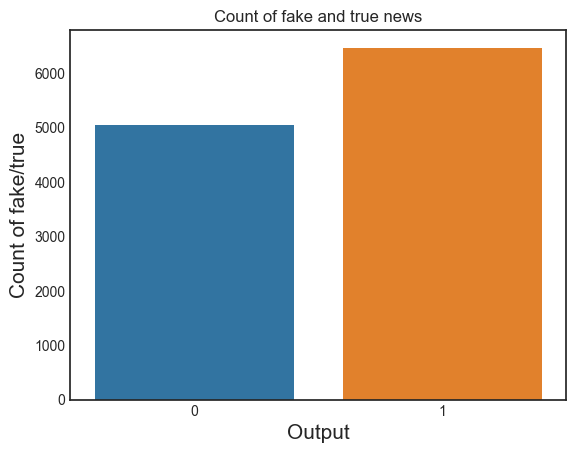

In [57]:
## Count of fake news and true news
ax=sns.countplot(x="label", data=Liar)
#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

In [58]:
Liar['label'].value_counts()

1    6465
0    5040
Name: label, dtype: int64

### Stemming

In [59]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(Liar)):
    news = re.sub('[^a-zA-Z]', ' ', str(Liar['news'][i]))
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news) 

In [60]:
Liar.head(3)

,news,state info,party affiliation,speaker's job title,polarity,speaker,word_count,the context,label
0,('energy history jobaccomplishmentswhen declin...,0,0,0,0.1,0,18,0,1
1,('foreignpolicyhillary clinton agrees john mcc...,1,0,1,0.0,1,13,1,1
2,('healthcarehealth care reform legislation lik...,-1,1,-1,0.2,2,11,2,0


In [61]:
#save point 4 after stemming 
Liar.to_csv(os.path.join(data_dir, 'Liar_stp_fS_fe_stm.csv'), index=False)

In [62]:
Liar= pd.read_csv(os.path.join(data_dir,'Liar_stp_fS_fe_stm.csv'))
Liar

,news,state info,party affiliation,speaker's job title,polarity,speaker,word_count,the context,label
0,('energy history jobaccomplishmentswhen declin...,0,0,0,0.100000,0,18,0,1
1,('foreignpolicyhillary clinton agrees john mcc...,1,0,1,0.000000,1,13,1,1
2,('healthcarehealth care reform legislation lik...,-1,1,-1,0.200000,2,11,2,0
3,('economy jobsthe economic turnaround started ...,2,0,-1,0.200000,3,8,3,1
4,('educationthe chicago bears starting quarterb...,3,2,2,0.000000,4,17,4,1
...,...,...,...,...,...,...,...,...,...
11500,('educationsays budget provides highest state ...,2,2,19,0.000000,27,10,22,1
11501,('civilrights crime criminaljusticeive almost ...,14,0,19,0.000000,1045,7,3799,0
11502,('bipartisanship congress foreignpolicy histor...,15,5,1273,-0.150000,3101,20,434,0
11503,('environment governmentefficiencysays epa per...,19,2,91,0.136364,163,14,22,0


In [63]:
train_dataset_adrs= os.path.join(data_dir,'train_data')
try:
    os.mkdir(train_dataset_adrs)
except  FileExistsError:
    pass

## Vectorization news column

### Bag of words

In [92]:
# bag of words
def bow(data):
    # Create a CountVectorizer object
    vectorizer = CountVectorizer()
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'],axis= 1).values) 
    vectorized_data= hstack([news_vectorized,rest]) 
    return vectorized_data


In [93]:
Liar_bow= bow(Liar)
# from now, the name of datasets will be changed based on vectorization techniques
#save point 5, Liar bag of words
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_bow.npz'), Liar_bow)
vec_tech_list= ['Liar_bow.npz']

### N-gram analysis

In [68]:
# one gram 
def one_gram(data):
    # Create a CountVectorizer object with unigrams
    vectorizer = CountVectorizer(ngram_range=(1, 1))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [69]:
Liar_one_gram= one_gram(Liar)
#save point 7, Liar one gram
vec_tech_list.append('Liar_one_gram.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_one_gram.npz'), Liar_one_gram)

In [70]:
# bigram 
def bigram(data):
    # Create a CountVectorizer object with unigrams
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [71]:
Liar_bigram= bigram(Liar)
#save point 8, Liar bigram
vec_tech_list.append('Liar_bigram.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_bigram.npz'), Liar_bigram)

In [72]:
# trigram 
def trigram(data):
    # Create a CountVectorizer object with trigrams
    vectorizer = CountVectorizer(max_features=10000, ngram_range=(3, 3))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [73]:
Liar_trigram= trigram(Liar)
#save point 9, Liar trigram
vec_tech_list.append('Liar_trigram.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_trigram.npz'), Liar_trigram)

In [74]:
# one to trigram 
def one_to_trigram(data):
    # Create a CountVectorizer object with unigrams
    vectorizer = CountVectorizer(ngram_range=(1, 3))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [75]:
Liar_one_to_trigram= one_to_trigram(Liar)
#save point 10, Liar one to trigram
vec_tech_list.append('Liar_one_to_trigram.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_one_to_trigram.npz'), Liar_one_to_trigram)

In [76]:
# TFIDF 
def TFIDF(data):
    # Create a TfidfVectorizer object with unigrams and bigrams
    vectorizer = TfidfVectorizer( ngram_range=(1, 2))
    # Fit and transform the "news" column
    news_vectorized = vectorizer.fit_transform(data['news'])
    # converting rest of features to sparse matrix to and concatenate with news columns which has been just vectorized
    rest= csr_matrix(data.drop(['news', 'label'], axis= 1).values)
    vectorized_data= hstack([news_vectorized,rest])
    return vectorized_data

In [77]:
Liar_TFIDF= TFIDF(Liar)
#save point 11, Liar TF
vec_tech_list.append('Liar_TFIDF.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_TFIDF.npz'), Liar_TFIDF)

In [78]:
# Word to Vector
def W2V(data):
    # Tokenize the text data
    tokenized_news = [word_tokenize(news) for news in data['news']]
    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)
    news_vectors = [model.wv[words] for words in tokenized_news]
    #converting vectorized list to np.array
#     news_vectors_array = np.array(news_vectors)
    news_vectors_mean = np.array([np.mean(vector_list, axis=0) for vector_list in news_vectors])
    rest= data.drop(['news','label'], axis= 1).values
    combined_features = np.hstack((news_vectors_mean, rest))
    return csr_matrix(combined_features)

In [79]:
Liar_W2V= W2V(Liar)
#save point 12, Liar Word to vector
vec_tech_list.append('Liar_W2V.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_W2V.npz'), Liar_W2V)

### combined vectorization techniques 

In [80]:
# Combine Bag-of-Words and Word2Vec vectorization methods
def bow_w2v(data):
    # Bag-of-Words (BoW) vectorization
    bow_vectorizer = CountVectorizer()
    bow_matrix = bow_vectorizer.fit_transform(data['news']).toarray()
    
    # Tokenize the text data for Word2Vec
    tokenized_news = [word_tokenize(news) for news in data['news']]
    
    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)
    
    # Compute the mean of word vectors for each news article
    w2v_vectors = [np.mean(w2v_model.wv[words], axis=0) for words in tokenized_news]
    
    # Convert the list of mean vectors to a 2D array
    w2v_vectors_array = np.array(w2v_vectors)
    # taking rest of selected features
    rest= data.drop(['news', 'label'], axis= 1).values
    # Combine BoW and Word2Vec vectors
    combined_vectors = np.hstack((bow_matrix, w2v_vectors_array, rest))
    
    return csr_matrix(combined_vectors)

In [81]:
# Call the vectorization function
Liar_bow_w2v = bow_w2v(Liar)
#save point 13, Liar bag of word and  Word to vector combined dataset
vec_tech_list.append('Liar_bow_w2v.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_bow_w2v.npz'), Liar_bow_w2v)


In [82]:
'''
Enhancing the result of Bag-of-Words (BoW) using Word2Vec can be done through
a technique known as "word embedding augmentation." The idea is to use the 
word vectors from Word2Vec to enhance the BoW representation of text. 
This can capture more semantic information and context compared to traditional BoW.
'''
def enhanc_bow_w2v(data):
    # Create BoW vectors using CountVectorizer
    bow_vectorizer = CountVectorizer()
    bow_matrix = bow_vectorizer.fit_transform(data['news']).toarray()

    # Tokenize the text data for Word2Vec
    tokenized_news = [word_tokenize(news) for news in data['news']]

    # Load a pre-trained Word2Vec model
    tokenized_news = [word_tokenize(news) for news in data['news']]
    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)

    # Enhance BoW using Word2Vec
    enhanced_bow_matrix = []
    for doc_tokens in tokenized_news:
        enhanced_bow_vector = np.zeros(len(bow_vectorizer.get_feature_names_out()))
        for token in doc_tokens:
            if token in w2v_model.wv:
                w2v_vector = w2v_model.wv[token]
                bow_index = bow_vectorizer.vocabulary_.get(token)
                enhanced_bow_vector[bow_index] = np.mean(w2v_vector)
        enhanced_bow_matrix.append(enhanced_bow_vector)

    enhanced_bow_matrix = np.array(enhanced_bow_matrix)
    rest= data.drop(['news', 'label'], axis= 1).values
    # Combine BoW and Word2Vec vectors
    combined_vectors = np.hstack((enhanced_bow_matrix, rest))
    # Convert the list of enhanced BoW vectors to a NumPy array
    return csr_matrix(combined_vectors)



In [83]:
Liar_enhanc_bow_w2v= enhanc_bow_w2v(Liar)
#save point 14, Liar bag of word and Word to vector enhanced combined dataset
vec_tech_list.append('Liar_enhanc_bow_w2v.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_enhanc_bow_w2v.npz'), Liar_enhanc_bow_w2v)

In [84]:
# Combine TFIDF and Word2Vec vectorization methods
def TFIDF_w2v(data):
    # Create a TfidfVectorizer object with unigrams and bigrams
    vectorizer = TfidfVectorizer( ngram_range=(1, 2))
    # Fit and transform the "news" column
    TFIDF_vectorized = vectorizer.fit_transform(data['news']).toarray()
    # Tokenize the text data for Word2Vec
    tokenized_news = [word_tokenize(news) for news in data['news']]
    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)  
    # Compute the mean of word vectors for each news article
    w2v_vectors = [np.mean(w2v_model.wv[words], axis=0) for words in tokenized_news] 
    # Convert the list of mean vectors to a 2D array
    w2v_vectors_array = np.array(w2v_vectors)
    # taking rest of selected features
    rest= data.drop(['news', 'label'], axis= 1).values
    # Combine BoW and Word2Vec vectors
    combined_vectors = np.hstack((TFIDF_vectorized, w2v_vectors_array, rest))
    
    return csr_matrix(combined_vectors)

In [85]:
# Call the vectorization function
Liar_TFIDF_w2v = TFIDF_w2v(Liar)
#save point 15, Liar TFIDF and  Word to vector combined dataset
vec_tech_list.append('Liar_TFIDF_w2v.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_TFIDF_w2v.npz'), Liar_TFIDF_w2v)

In [ ]:
Liar_TFIDF_w2v.shape

In [86]:
'''
Enhancing the result of TFIDF using Word2Vec can be done through
a technique known as "word embedding augmentation." The idea is to use the 
word vectors from Word2Vec to enhance the BoW representation of text. 
This can capture more semantic information and context compared to traditional BoW.
'''
def enhance_TFIDF_w2v(data):
    # Create TF-IDF vectors using TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform(data['news']).toarray()

    # Tokenize the text data for Word2Vec
    tokenized_news = [word_tokenize(news) for news in data['news']]

    # Load a pre-trained Word2Vec model
    tokenized_news = [word_tokenize(news) for news in data['news']]
    # Train Word2Vec model
    w2v_model = Word2Vec(sentences=tokenized_news, vector_size=100, window=5, min_count=1, sg=0)

    # Enhance BoW using Word2Vec
    enhanced_bow_matrix = []
    for doc_tokens in tokenized_news:
        enhanced_bow_vector = np.zeros(len(tfidf_vectorizer.get_feature_names_out()))
        for token in doc_tokens:
            if token in w2v_model.wv:
                w2v_vector = w2v_model.wv[token]
                bow_index = tfidf_vectorizer.vocabulary_.get(token)
                enhanced_bow_vector[bow_index] = np.mean(w2v_vector)
        enhanced_bow_matrix.append(enhanced_bow_vector)

    enhanced_bow_matrix = np.array(enhanced_bow_matrix)
    rest= data.drop(['news', 'label'], axis= 1).values
    # Combine BoW and Word2Vec vectors
    combined_vectors = np.hstack((enhanced_bow_matrix, rest))
    # Convert the list of enhanced BoW vectors to a NumPy array
    return csr_matrix(combined_vectors)

In [87]:
Liar_enhance_TFIDF_w2v= enhance_TFIDF_w2v(Liar)
# save point 16, Liar bag of word and  Word to vector enhanced combined dataset
vec_tech_list.append('Liar_enhance_TFIDF_w2v.npz')
scipy.sparse.save_npz(os.path.join(train_dataset_adrs,'Liar_enhance_TFIDF_w2v.npz'), Liar_enhance_TFIDF_w2v)

In [88]:
Liar_enhance_TFIDF_w2v.shape

(11505, 17585)

In [97]:
label= Liar['label']
label.shape

(11505,)

In [98]:
# saving label column in a sperate sparce matrix file
label.to_csv(os.path.join(train_dataset_adrs, 'Liar_label.csv'), index= False)